# **HW4P1: Language Modelling**

Welcome to the final Part 1 HW of this course. This is the only part 1 in which you have PyTorch training (Yay!). You will be working on training language models and evaluating them on the task of prediction and generation.<br>

As you go, please read the code and keep an eye out for TODOs.

Structure of this notebook:

- **Imports and installs** - specify the correct data paths and mostly just run it.
- **Datasets** - complete TODO and run it.
- **Dataloader** - complete TODO and run it.
- **Language model architecture** - implement and define your preferred model architecture based on the writeup.
- **Dataloader, model, loss, optimizer, and scheduler definition** - define your dataloader, model, loss, optimizer, and scheduler.
- **Trainer class** - unlike all the P2s, we are using a Trainer class for this HW, review the class and complete the train function.
- **Wandb** - add a correct API key.
- **Experiments** - just run your experiments and note the resulting NLL metric.
- **Evaluation** - get access to OpenAI API to get the resulting perplexity metric.
- **Submission** - create a handin for Autolab.

# **Imports and installs**

In [1]:
# !tar -xvf /content/hw4p1_handout.tar

In [2]:
# !pip install torchsummaryX
# !pip install wandb --quiet
# !pip install matplotlib

# !pip install -q cohere tiktoken openai
# !pip install openai==0.28``

In [3]:
# TODO: Import drive if you are using Colab

In [4]:
# You can upload entire working directory of HW4P1 to google drive and access the files from there

import sys
sys.path
# path = NotImplemented # TODO: Add path to handout. For example "content/handout"
# sys.path.append(path)
# %cd {path}

['/mnt/w/Sync/Courses/24 Spring/11785 IDL/hw/hw4/HW4P1/hw4',
 '',
 '/opt/ros/humble/lib/python3.10/site-packages',
 '/opt/ros/humble/local/lib/python3.10/dist-packages',
 '/home/zzy/miniconda3/envs/11785/lib/python311.zip',
 '/home/zzy/miniconda3/envs/11785/lib/python3.11',
 '/home/zzy/miniconda3/envs/11785/lib/python3.11/lib-dynload',
 '/home/zzy/miniconda3/envs/11785/lib/python3.11/site-packages']

In [5]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchsummaryX
import gc
import wandb
import yaml
import openai

# Importing necessary modules from hw4
# Update the path depending on how you choose to load the handout
from tests_hw4 import get_prediction_nll, make_generation_text

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# # print("Device: ", DEVICE)

# **Datasets**

In [6]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('../dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']


In [7]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('../dataset/wiki.train.npy', allow_pickle=True)

# The dataset does not have <sos> and <eos> because they are just regular articles.
# TODO: Add <sos> and <eos> to every article in the dataset.
# Before doing so, try printing the dataset to see if they are words or integers.
articles = []
for i in range(dataset.shape[0]):
    article = dataset[i]
    article = np.insert(article, 0, SOS_TOKEN)
    article = np.append(article, EOS_TOKEN)
    # articles = np.vstack((articles, article))
    articles.append(article)
dataset = articles

In [8]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('../fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('../fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [9]:
# Loading the test fixtures for generation
fixtures_gen_test   = np.load('../fixtures/generation_test.npy')   # test

print("Test Gen Shapes          :", fixtures_gen_test.shape)

Test Gen Shapes          : (128, 31)


In [10]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs
dataset[0].shape, dataset[1].shape

((3805,), (4003,))

# **Dataloader**

In [11]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, sequence_length=3, shuffle= True, drop_last= False):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.sequence_length = sequence_length
        self.dataset_concatenated = np.concatenate(dataset)


    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length

        total_length = np.sum([self.dataset[i].shape[0] for i in range(len(self.dataset))])
        # print("checkLen", total_length)

        batch_count = total_length //(self.batch_size*self.sequence_length)
        return batch_count

    def __iter__(self):
        # TODO: Shuffle data if shuffle is True
        
        if self.shuffle:
            # TODO
            np.random.shuffle(self.dataset)

        # TODO: Set number of batches
        num_batches = self.__len__()
        
        batches = []
        
        self.dataset_concatenated = np.concatenate(dataset)
        
        for b in range(num_batches):
            batch = self.dataset_concatenated[b*self.batch_size*self.sequence_length:(b+1)*self.batch_size*self.sequence_length+1]
            batches.append(batch)
            
        if self.drop_last:
            batches = batches[:-1]
            

        # TODO: Divide the concetenated dataset into inputs and targets. How do they vary?

        # TODO: Reshape the inputs and targets into batches (think about the final shape)

        # TODO: Loop though the batches and yield the input and target batch according to the sequence length
        batch_idx = 0
        
        while batch_idx < batches.__len__():
            input = batches[batch_idx][:-1].reshape(self.batch_size, self.sequence_length)
            target = batches[batch_idx][1:].reshape(self.batch_size, self.sequence_length)
            batch_idx += 1
            # print("checkOutput", input.shape, target.shape)
            yield torch.tensor(input), torch.tensor(target)


In [12]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 32,
    sequence_length = 20,
    shuffle     = True,
    drop_last   = True,
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)
print(dl.__len__())

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

torch.Size([32, 20]) torch.Size([32, 20])
3245
x:  ['<sos>', '=', 'Simon', 'Bradstreet', '=', '<eol>', 'Simon', 'Bradstreet', '(', 'baptized', 'March', '18', ',', '1603', '/', '4', '–', 'March', '27', ',']
y:  ['=', 'Simon', 'Bradstreet', '=', '<eol>', 'Simon', 'Bradstreet', '(', 'baptized', 'March', '18', ',', '1603', '/', '4', '–', 'March', '27', ',', '1697']


# **Language model architecture**

Recurrent network, one-directional or bidirectional, captures certain patterns within a sequence, and can store them into state vector or pass into output. As with convolutional networks, we can build another recurrent layer on top of the first one to capture higher level patterns, build from low-level patterns extracted by the first layer. This leads us to the notion of multi-layer RNN, which consists of two or more recurrent networks, where output of the previous layer is passed to the next layer as input.

**Link to PyTorch Documentation**: [LSTM Cell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

The following image can be a helpful aid in visualizing the flow of information in a multi-layer RNN with LSTM Cells.

<img src="https://raw.githubusercontent.com/microsoft/AI-For-Beginners/32043fd2c98de6bbcae857058ac38aaa8140b142/lessons/5-NLP/16-RNN/images/multi-layer-lstm.jpg">




In [13]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2.
# However, using LSTMCells presents an opportunity to learn something different

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embed_dim, hid_dim): # TODO: Add more parameters as needed
        super().__init__()

        # For all the layers which you will define, please read the documentation thoroughly before implementation
        # TODO: Define a PyTorch embedding layer
        self.token_embedding    = torch.nn.Embedding(num_embeddings= vocab_size, embedding_dim = embed_dim)

        self.lstm_cells = [
            torch.nn.LSTMCell(input_size = embed_dim, hidden_size = hid_dim),
            torch.nn.LSTMCell(input_size = hid_dim, hidden_size = hid_dim)
        ]

        for cell in self.lstm_cells:
            cell.apply(self.init_weights)
        
        self.lstm_cells = torch.nn.Sequential(*self.lstm_cells)

        # TODO: Define the parameters
        self.token_probability  = torch.nn.Linear(hid_dim, vocab_size)

        # (Optional) TODO: Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight.

        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def init_weights(self, m):
        if type(m) == torch.nn.LSTMCell:
            for name, param in m.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param.data)  # Xavier Uniform initialization
                    # torch.nn.init.orthogonal_(param.data)  # Orthogonal initialization
                    # torch.nn.init.normal_(param.data, mean=0, std=1)  # Normal initialization
                elif 'bias' in name:
                    param.data.fill_(0.01)  # Constant initialization
    
    def rnn_step(self, embedding, hidden_states_list):
        next_hidden_states_list = list(hidden_states_list) # Length of the hidden_states_list is same as lstm cells
        token_embedding = embedding
        for i, lstm in enumerate(self.lstm_cells):
            # print(token_embedding.shape, next_hidden_states_list[-1])
            hx, cx = lstm.forward(input=token_embedding, hx=next_hidden_states_list[-1])
            # print(hx.shape, cx.shape)
            # raise EOFError
            next_hidden_states_list[i] = (hx, cx)
            token_embedding = hx

        return token_embedding, next_hidden_states_list

    def predict(self, x):
        # Refer to Section 1.2.6 to understand this function
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        with torch.inference_mode():
            # TODO: Pass the input sequence through the model
            # and return the probability distribution of the last timestep
            prob, _ = self.forward(x)
            
            return prob[:, -1, :]

    def generate(self, x, timesteps):
        # Refer to section 1.2.4 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup

        timesteps -= 1
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # TODO: Pass the input sequence through the model
        # Obtain the probability distribution and hidden_states_list of the last timestep
        token_prob_dist, hidden_states_list     = self.forward(x)

        # TODO: Draw the next predicted token from the probability distribution ()
        next_token                              = token_prob_dist.argmax(dim= -1)
        # print(timesteps, x.shape, next_token.shape)

        # What would generated_sequence be initialized with?
        generated_sequence  = [next_token]
        with torch.inference_mode():
            for t in range(timesteps): # Loop through the timesteps

                # TODO: Pass the next_token and hidden_states_list through the model
                token_prob_dist, hidden_states_list = self.forward(next_token, hidden_states_list)
                # TODO: You will get 2 outputs. What is the shape of the probability distribution?

                # TODO: Get the most probable token for the next timestep
                next_token = token_prob_dist.argmax(dim= -1)
                generated_sequence.append(next_token)
                # torch.cuda.empty_cache()

            generated_sequence = torch.stack(generated_sequence, dim= 1)[:, -1, :] # keep last timesteps generated words
        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        # x (Batch, Seq_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious
        x = x.long()

        batch_size, timesteps   = x.shape

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps

        # Initializing the hidden hidden_states_list
        # Are the elements of the hidden_states_list individual variables or lists of variables themselves?
        # Hint: Refer the PyTorch documentation for the answer
        hidden_states_list      = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list

        token_embeddings        = self.token_embedding(x) # (Batch, Seq_len, Embed_dim)

        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            token_embedding_t   = token_embeddings[:, t, :] # (Batch, Embed_dim)

            # TODO (What should you do with the hidden_states_list?)
            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list)

            # Map the RNN output to the vocabulary’s dimension and store it in token_prob_dist_t,
            # the token probability distribution at time t.
            token_prob_dist_t   = self.token_probability(rnn_out)

            # Append token_prob_dist_t to a list of token probability distributions.
            token_prob_distribution.append(token_prob_dist_t)

        # TODO: Stack along the timesteps dimension
        token_prob_distribution = torch.stack(token_prob_distribution, dim= 1)

        return token_prob_distribution, hidden_states_list

# **Dataloader, model, loss, optimizer, and scheduler definition**

In [14]:
# TODO: Define other hyperparameters

config = dict(
    batch_size  = 256,
    num_epochs  = 30, # 10 to 20 epochs should be enough given the model is good
    init_lr     = 0.001,
)

In [15]:
import torchinfo
# --------------------------------------------------- #

# TODO: Define the dataloader
loader = DataLoaderForLanguageModeling(dataset, batch_size = config['batch_size'], sequence_length = 20, shuffle = True, drop_last = True)

# --------------------------------------------------- #

# TODO: Define the model
model = LanguageModel(vocab_size = len(VOCAB), embed_dim=128, hid_dim=128).to(DEVICE)

# --------------------------------------------------- #

# TODO: Define the criterion
criterion   = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# TODO: Define the optimizer
## Adam/AdamW usually works good for this HW
optimizer   = torch.optim.AdamW(model.parameters(), lr = config['init_lr'])

# --------------------------------------------------- #

# TODO: Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.2, patience = 3, verbose = True)

# --------------------------------------------------- #

#TODO: Define scaler for mixed precision
# scaler = NotImplemented

print(model)
inputs, targets = next(iter(loader))
print(inputs.shape, targets.shape)
print(loader.__len__())
torchinfo.summary(model.to(DEVICE), input_data=inputs.to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 128)
  (lstm_cells): Sequential(
    (0): LSTMCell(128, 128)
    (1): LSTMCell(128, 128)
  )
  (token_probability): Linear(in_features=128, out_features=33280, bias=True)
)
torch.Size([256, 20]) torch.Size([256, 20])
405


Layer (type:depth-idx)                   Output Shape              Param #
LanguageModel                            [256, 20, 33280]          264,192
├─Embedding: 1-1                         [256, 20, 128]            4,259,840
├─Linear: 1-2                            [256, 33280]              4,293,120
├─Linear: 1-3                            [256, 33280]              (recursive)
├─Linear: 1-4                            [256, 33280]              (recursive)
├─Linear: 1-5                            [256, 33280]              (recursive)
├─Linear: 1-6                            [256, 33280]              (recursive)
├─Linear: 1-7                            [256, 33280]              (recursive)
├─Linear: 1-8                            [256, 33280]              (recursive)
├─Linear: 1-9                            [256, 33280]              (recursive)
├─Linear: 1-10                           [256, 33280]              (recursive)
├─Linear: 1-11                           [256, 33280]           

# **Trainer class**

In [16]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, scaler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler
        self.scaler     = scaler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.reshape(-1, out.shape[-1]) 
        targets = target.reshape(-1)
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0 # what this for?

        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):

            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Use Mixed Precision Training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.

            inputs = torch.tensor(inputs).long().to(DEVICE)
            targets = torch.tensor(targets).long().to(DEVICE)

            self.optimizer.zero_grad()

            # with torch.cuda.amp.autocast():
            #   # Add code here
            #   pass
            
            out,_ = self.model(inputs)
            loss = self.calculate_loss(out, targets)
            
            loss_item = loss.item()
            epoch_loss += loss_item

            # TODO: Add backward and, optimiser step and scaler update code here:
            loss.backward()
            self.optimizer.step()
            # self.scheduler.step(loss)
        
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                    % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)

        return (epoch_loss, self.optimizer.param_groups[0]['lr'])



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        prediction_probs     = self.model.predict(fixtures_pred['inp']) # get predictions
        prediction_probs = prediction_probs.clone().detach().cpu().numpy()
        self.prediction_probs.append(prediction_probs)

        generated_indexes_test   = self.model.generate(fixtures_gen_test, 10).detach().cpu().numpy() # generated predictions for 10 words

        # print(generated_indexes_test.shape)
        nll                   = get_prediction_nll(prediction_probs, fixtures_pred['out'])
        generated_texts_test  = make_generation_text(fixtures_gen_test, generated_indexes_test, VOCAB)
        self.val_losses.append(nll)

        self.generated_texts_test.append(generated_texts_test)

        # generate predictions for test data
        prediction_probs_test = self.model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs_test.append(prediction_probs_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll


    def save(self): # Don't change this function

        model_path = os.path.join('../hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('../hw4/experiments', self.run_id, 'prediction-probs-{}.npy'.format(self.epochs)), self.prediction_probs[-1])
        np.save(os.path.join('../hw4/experiments', self.run_id, 'prediction-probs-test-{}.npy'.format(self.epochs)), self.prediction_probs_test[-1])

        with open(os.path.join('../hw4/experiments', self.run_id, 'generated-texts-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_texts_test[-1])

In [17]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('../hw4/experiments'):
    os.mkdir('../hw4/experiments')
os.mkdir('../hw4/experiments/%s' % run_id)
print("Saving models, prediction prbabilities, and generated texts to ../hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,
    scaler      = None,
    max_epochs  = config['num_epochs'],
    run_id      = run_id
)

Saving models, prediction prbabilities, and generated texts to ../hw4/experiments/1713235126


# **Wandb**

In [18]:
# # Use wandb? Resume Training?
# USE_WANDB = True
# RESUME_LOGGING = False

# # Create your wandb run

# run_name = NotImplemented

# if USE_WANDB:

#     wandb.login(key=NotImplemented)

#     if RESUME_LOGGING:
#         run_id = ''
#         run = wandb.init(
#             id     = run_id, ### Insert specific run id here if you want to resume a previous run
#             resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
#             project = "hw4p1-s24", ### Project should be created in your wandb account
#         )
#     else:
#         run = wandb.init(
#             name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
#             reinit  = True, ### Allows reinitalizing runs when you re-run this cell
#             project = "hw4p1-s24", ### Project should be created in your wandb account
#             config  = config ### Wandb Config for your run
#         )

#         ### Save your model architecture as a string with str(model)
#         model_arch  = str(model)
#         ### Save it in a txt file
#         arch_file   = open("model_arch.txt", "w")
#         file_write  = arch_file.write(model_arch)
#         arch_file.close()

#         ### log it in your wandb run with wandb.save()
#         wandb.save('model_arch.txt')

# **Experiments**

In [19]:
# trainer.test()

In [20]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

# wandb.watch(model, log="all")

torch.cuda.empty_cache()
gc.collect()

# %%time
best_nll = 1e30
for epoch in range(config['num_epochs']):
    train_loss, curr_lr = trainer.train()
    nll = trainer.test()
    print("Epoch: ", epoch+1, "NLL: ", nll, "Best NLL: ", best_nll)
    scheduler.step(nll)
    if nll < best_nll:
        best_nll = nll
        print("Saving model, prediction probabilities and generated texts for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

    # wandb.log({"train_loss":train_loss,
    #            "nll": nll,
    #            "learning_rate": curr_lr
    #           })

### Finish your wandb run
# run.finish()

  0%|          | 0/405 [00:00<?, ?it/s]/tmp/ipykernel_40639/3181274751.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).long().to(DEVICE)
/tmp/ipykernel_40639/3181274751.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).long().to(DEVICE)
100%|█████████▉| 404/405 [00:07<00:00, 52.72it/s]


[TRAIN] 	Epoch [1/30] 	Loss: 7.4309 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [1/30] 	Loss: 6.3990
Epoch:  1 NLL:  6.3990116 Best NLL:  1e+30
Saving model, prediction probabilities and generated texts for epoch 1 with NLL: 6.3990116


100%|█████████▉| 404/405 [00:07<00:00, 53.56it/s]


[TRAIN] 	Epoch [2/30] 	Loss: 6.7535 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [2/30] 	Loss: 5.9931
Epoch:  2 NLL:  5.9931355 Best NLL:  6.3990116
Saving model, prediction probabilities and generated texts for epoch 2 with NLL: 5.993135

100%|█████████▉| 404/405 [00:07<00:00, 53.67it/s]


[TRAIN] 	Epoch [3/30] 	Loss: 6.4595 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [3/30] 	Loss: 5.7715
Epoch:  3 NLL:  5.7714663 Best NLL:  5.9931355
Saving model, prediction probabilities and generated texts for epoch 3 with NLL: 5.771466

100%|█████████▉| 404/405 [00:07<00:00, 53.71it/s]


[TRAIN] 	Epoch [4/30] 	Loss: 6.2603 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [4/30] 	Loss: 5.6455
Epoch:  4 NLL:  5.6454744 Best NLL:  5.7714663
Saving model, prediction probabilities and generated texts for epoch 4 with NLL: 5.645474

100%|█████████▉| 404/405 [00:07<00:00, 53.54it/s]


[TRAIN] 	Epoch [5/30] 	Loss: 6.1037 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [5/30] 	Loss: 5.5522
Epoch:  5 NLL:  5.552205 Best NLL:  5.6454744
Saving model, prediction probabilities and generated texts for epoch 5 with NLL: 5.552205


100%|█████████▉| 404/405 [00:07<00:00, 53.63it/s]


[TRAIN] 	Epoch [6/30] 	Loss: 5.9719 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [6/30] 	Loss: 5.4279
Epoch:  6 NLL:  5.427873 Best NLL:  5.552205
Saving model, prediction probabilities and generated texts for epoch 6 with NLL: 5.427873


100%|█████████▉| 404/405 [00:07<00:00, 53.50it/s]


[TRAIN] 	Epoch [7/30] 	Loss: 5.8680 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [7/30] 	Loss: 5.3444
Epoch:  7 NLL:  5.3443546 Best NLL:  5.427873
Saving model, prediction probabilities and generated texts for epoch 7 with NLL: 5.3443546

100%|█████████▉| 404/405 [00:07<00:00, 53.67it/s]


[TRAIN] 	Epoch [8/30] 	Loss: 5.7752 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [8/30] 	Loss: 5.2577
Epoch:  8 NLL:  5.257718 Best NLL:  5.3443546
Saving model, prediction probabilities and generated texts for epoch 8 with NLL: 5.257718


100%|█████████▉| 404/405 [00:07<00:00, 53.62it/s]


[TRAIN] 	Epoch [9/30] 	Loss: 5.6936 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [9/30] 	Loss: 5.1956
Epoch:  9 NLL:  5.195648 Best NLL:  5.257718
Saving model, prediction probabilities and generated texts for epoch 9 with NLL: 5.195648


100%|█████████▉| 404/405 [00:07<00:00, 53.50it/s]


[TRAIN] 	Epoch [10/30] 	Loss: 5.6198 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [10/30] 	Loss: 5.1375
Epoch:  10 NLL:  5.137533 Best NLL:  5.195648
Saving model, prediction probabilities and generated texts for epoch 10 with NLL: 5.1375

100%|█████████▉| 404/405 [00:07<00:00, 53.84it/s]


[TRAIN] 	Epoch [11/30] 	Loss: 5.5555 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [11/30] 	Loss: 5.0529
Epoch:  11 NLL:  5.0528774 Best NLL:  5.137533
Saving model, prediction probabilities and generated texts for epoch 11 with NLL: 5.052

100%|█████████▉| 404/405 [00:07<00:00, 54.50it/s]


[TRAIN] 	Epoch [12/30] 	Loss: 5.4957 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [12/30] 	Loss: 5.0400
Epoch:  12 NLL:  5.040036 Best NLL:  5.0528774
Saving model, prediction probabilities and generated texts for epoch 12 with NLL: 5.040

100%|█████████▉| 404/405 [00:07<00:00, 54.38it/s]


[TRAIN] 	Epoch [13/30] 	Loss: 5.4383 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [13/30] 	Loss: 4.9426
Epoch:  13 NLL:  4.942569 Best NLL:  5.040036
Saving model, prediction probabilities and generated texts for epoch 13 with NLL: 4.9425

100%|█████████▉| 404/405 [00:08<00:00, 50.46it/s]


[TRAIN] 	Epoch [14/30] 	Loss: 5.3837 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [14/30] 	Loss: 4.9305
Epoch:  14 NLL:  4.930463 Best NLL:  4.942569
Saving model, prediction probabilities and generated texts for epoch 14 with NLL: 4.9304

100%|█████████▉| 404/405 [00:07<00:00, 52.37it/s]


[TRAIN] 	Epoch [15/30] 	Loss: 5.3343 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [15/30] 	Loss: 4.9839
Epoch:  15 NLL:  4.983934 Best NLL:  4.930463


100%|█████████▉| 404/405 [00:07<00:00, 53.19it/s]


[TRAIN] 	Epoch [16/30] 	Loss: 5.2877 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [16/30] 	Loss: 4.8743
Epoch:  16 NLL:  4.8743153 Best NLL:  4.930463
Saving model, prediction probabilities and generated texts for epoch 16 with NLL: 4.874

100%|█████████▉| 404/405 [00:07<00:00, 52.68it/s]


[TRAIN] 	Epoch [17/30] 	Loss: 5.2436 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [17/30] 	Loss: 4.8579
Epoch:  17 NLL:  4.857854 Best NLL:  4.8743153
Saving model, prediction probabilities and generated texts for epoch 17 with NLL: 4.857

100%|█████████▉| 404/405 [00:07<00:00, 54.08it/s]


[TRAIN] 	Epoch [18/30] 	Loss: 5.1994 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [18/30] 	Loss: 4.7638
Epoch:  18 NLL:  4.7637873 Best NLL:  4.857854
Saving model, prediction probabilities and generated texts for epoch 18 with NLL: 4.763

100%|█████████▉| 404/405 [00:07<00:00, 54.42it/s]


[TRAIN] 	Epoch [19/30] 	Loss: 5.1602 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [19/30] 	Loss: 4.7837
Epoch:  19 NLL:  4.783743 Best NLL:  4.7637873


100%|█████████▉| 404/405 [00:07<00:00, 53.21it/s]


[TRAIN] 	Epoch [20/30] 	Loss: 5.1217 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [20/30] 	Loss: 4.8007
Epoch:  20 NLL:  4.8007393 Best NLL:  4.7637873


100%|█████████▉| 404/405 [00:07<00:00, 51.79it/s]


[TRAIN] 	Epoch [21/30] 	Loss: 5.0846 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [21/30] 	Loss: 4.7666
Epoch:  21 NLL:  4.7665977 Best NLL:  4.7637873


100%|█████████▉| 404/405 [00:07<00:00, 52.77it/s]


[TRAIN] 	Epoch [22/30] 	Loss: 5.0492 	Lr: 0.001000
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [22/30] 	Loss: 4.7980
Epoch:  22 NLL:  4.7979765 Best NLL:  4.7637873
Epoch 00022: reducing learning rate of group 0 to 2.0000e-04.


100%|█████████▉| 404/405 [00:07<00:00, 53.03it/s]


[TRAIN] 	Epoch [23/30] 	Loss: 4.9643 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [23/30] 	Loss: 4.7358
Epoch:  23 NLL:  4.7358265 Best NLL:  4.7637873
Saving model, prediction probabilities and generated texts for epoch 23 with NLL: 4.73

100%|█████████▉| 404/405 [00:07<00:00, 52.96it/s]


[TRAIN] 	Epoch [24/30] 	Loss: 4.9516 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [24/30] 	Loss: 4.7468
Epoch:  24 NLL:  4.7468147 Best NLL:  4.7358265


100%|█████████▉| 404/405 [00:07<00:00, 52.66it/s]


[TRAIN] 	Epoch [25/30] 	Loss: 4.9425 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [25/30] 	Loss: 4.7456
Epoch:  25 NLL:  4.74562 Best NLL:  4.7358265


100%|█████████▉| 404/405 [00:07<00:00, 54.51it/s]


[TRAIN] 	Epoch [26/30] 	Loss: 4.9349 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [26/30] 	Loss: 4.7256
Epoch:  26 NLL:  4.725598 Best NLL:  4.7358265
Saving model, prediction probabilities and generated texts for epoch 26 with NLL: 4.725

100%|█████████▉| 404/405 [00:07<00:00, 54.63it/s]


[TRAIN] 	Epoch [27/30] 	Loss: 4.9287 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [27/30] 	Loss: 4.7263
Epoch:  27 NLL:  4.726281 Best NLL:  4.725598


100%|█████████▉| 404/405 [00:07<00:00, 54.61it/s]


[TRAIN] 	Epoch [28/30] 	Loss: 4.9209 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [28/30] 	Loss: 4.7760
Epoch:  28 NLL:  4.775977 Best NLL:  4.725598


100%|█████████▉| 404/405 [00:07<00:00, 54.59it/s]


[TRAIN] 	Epoch [29/30] 	Loss: 4.9137 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [29/30] 	Loss: 4.7604
Epoch:  29 NLL:  4.760352 Best NLL:  4.725598


100%|█████████▉| 404/405 [00:07<00:00, 54.40it/s]


[TRAIN] 	Epoch [30/30] 	Loss: 4.9068 	Lr: 0.000200
[   72 24820 21959    79  1419 25821 13052  3909  1419  2118 31190 24567
 32747  6085 26516  1419 31353 29478 22356 14658  1420 13710 22534  1512
 25821 31353 26874 25821 29310  1794 16004 31293 21626    76  1424     1
 25177  1311    76 31352 31353    76  2858  1417 23318   373     1 15111
 31353    76    79 19085 23592    76 12959     1 25871 25821 22633  1423
 31589  1419 22845 18261  1424 31353 32873 19623 31353 16077  1424 26375
 31352 27417 32883 17135 31429    79 31994 31673 25525 22968 31353 13276
 25821 31514  1424 14658  1417 11475 31994 29707 25821 26753 22968 33248
 17731 32209 16672 24098 25410 31353 27904 28296 10120    79 31353  1417
 15898    76 15340 15577  1420 14247 31205  1419 32883    79 19652   869
 14118 25639 15310 15391 31353 29294  5172  8881]
[VAL] 	Epoch [30/30] 	Loss: 4.7307
Epoch:  30 NLL:  4.730708 Best NLL:  4.725598
Epoch 00030: reducing learning rate of group 0 to 4.0000e-05.


In [21]:
torch.cuda.empty_cache()
gc.collect()

451

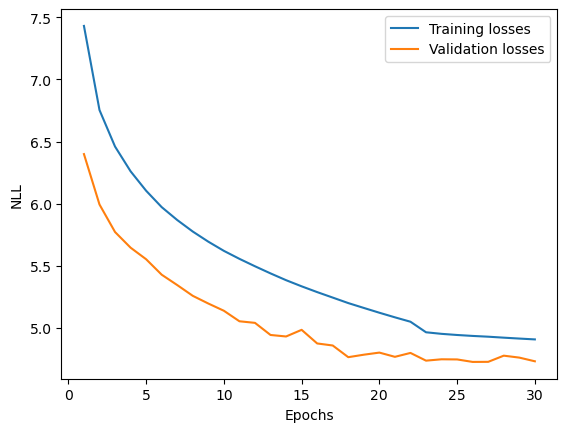

In [22]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# **Evaluation**

 - Now that you have trained your model and got satisfactory validation NLL on the single token prediction task, you can evaluate the generations you created too
 - We will use the perplexity metric to evaluate generations using a large language model available through the OpenAI API. Read the handout for instructions on how to sign up for the API and obtain and API key.
 - Once you add credits to your account, run this cell to get the perplexity.
 - You will submit this perplexity value for grading the generation component of this homework.
 - A perplexity of under **1400** will give you full credit on the generation part.

Change only the **submission_run_id**, **submission_epoch**, and **api_key** in the following cell

In [26]:
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT submission_run_id, submission_epoch, AND api_key
# PLEASE BE HONEST IN REPORTING THE PERPLEXITY VALUE!
# WE WILL RANDOMLY CHECK SOME SUBMISSIONS USING THE SAME CODE AS THIS AND A BIG DIFFERENCE IN PERPLEXITY WILL RESULT IN AN AIV.

import openai
import json

openai.api_key = json.load(open("../../../safestore.json")).get("openai_api_key")


# Add you submission_run_id and submission_epoch here --------------------------------------------------
# Fill the run id and epoch number to be used for submission.
# You will use the same run id and epoch number to generate the handin.

submission_run_id = run_id # TODO
submission_epoch = 26 # TODO

# --------------------------------------------------------------

n_tests = 128

with open(os.path.join('./experiments', submission_run_id, 'generated-texts-{}-test.txt'.format(submission_epoch)), 'r', encoding='utf-8') as f:
    generated = list(f)

assert len(generated) == n_tests
for item in generated:
    assert type(item) is str

parsed_generated = []

for text in generated:
    start_index = text.index("<sos>")
    temp = text[start_index+6:]
    generation_start_index = temp.index("| ")
    parsed_text = temp[:generation_start_index] + temp[generation_start_index+2:]
    parsed_text = parsed_text.replace("<eol>", "\n")
    parsed_generated.append(parsed_text)

def perplexity(text, modelname):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=modelname,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    ll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-ll)
    return ppl

# Add you API key here --------------------------------------------------
# However, delete the key from the notebook before creating the handin.
# REMEMBER: ALWAYS KEEP YOUR API KEYS AND SECRETS SECURE.

# --------------------------------------------------------------

modelname = 'text-embedding-ada-002'

perps = [perplexity(text, modelname) for text in tqdm(parsed_generated)]
avg_perp = np.mean(perps)

# Report this number when running the makefile to create the handin
print("Your mean perplexity for generated sequences: {}".format(avg_perp))

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:36<00:00,  3.51it/s]

Your mean perplexity for generated sequences: 445.90097113231025


**NOTE**:
- If you get a "The server is overloaded or not ready yet" when trying to run the above cell, simply try re-running after some time.
- You will need to add credits ($5) to your open-ai account to get rid of the limit error.

# **Submission**
Navigate to the handout directory to run the below cell. This command will create the handin with all the required files (including attention.py). So make sure you have the entire handout directory wherever you are running this notebook (local machine, Colab, AWS, etc.).

**IMPORTANT NOTE:** This command requires that this c**ompleted notebook be in the hw4 folder inside the handout directory**. If you are on colab, this notebook you are working on **DOES NOT** live in the handout directory. You must **download it and then upload it** to the hw4 folder replacing the empty starter notebook.

In [28]:
# TODO: Generate the handin to submit to autolab

# For example:
# !make runid=1705009752 epoch=9 ppl=1287.0752467922216

!cd .. && make runid=1713235126 epoch=26 ppl=445.90097113231025

echo 445.90097113231025 > generation_ppl.txt
cp hw4/experiments/1713235126/prediction-probs-test-26.npy prediction_probs.npy
cp hw4/experiments/1713235126/generated-texts-26-test.txt generated_texts.txt
cp hw4/hw4p1.ipynb training.ipynb
cp hw4/attention.py attention.py
tar -cvzf handin.tar training.ipynb prediction_probs.npy generated_texts.txt generation_ppl.txt attention.py
training.ipynb
prediction_probs.npy
generated_texts.txt
generation_ppl.txt
attention.py
rm -f generated_texts.txt prediction_probs.npy training.ipynb generation_ppl.txt attention.py
